In [1]:
import sys
import numpy as np
import nifty7 as ift
import matplotlib.pyplot as plt
from functools import reduce
from operator import add

In [2]:
sys.path.append('../')

In [3]:
import src as grav

In [4]:
grav.set_style('plotstyle')

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fs = plt.rcParams['figure.figsize']

# Load data and imaging solution

In [6]:
results_path = '../../../results/2021-12-10_code-cleanup/'
data_file    = '../../../data/mock-data.fits'
sys.path.append(results_path)

In [7]:
from mockrun3_config import *
invG_param['domain'] = image_domain

In [8]:
cmap_file = '../calibration/aberration-maps/'+ cmap_file

In [9]:
imagin_result = np.load(results_path+'mockrun3_p030.npy', allow_pickle=True).item()
pos_final     = imagin_result['position']
samples       = imagin_result['samples']

In [10]:
data = grav.read_data(data_file, min_channel=min_channel, max_channel=max_channel, polarization=polarization,
                     trange=time_range, idx_frame_exclude=idx_frame_exclude)

In [11]:
data['spi'] = sigma_phi_scale*data['spi']
data['sro'] = sigma_amp_scale*data['sro']
data['t3e'] = sigma_t3p_scale*data['t3e']

In [12]:
print('phi error scaling = ', sigma_phi_scale)
print('rho error scaling = ', sigma_amp_scale)
print('t3p error scaling = ', sigma_t3p_scale)

phi error scaling =  1.0
rho error scaling =  1.0
t3p error scaling =  1.0


In [13]:
grav.message_data_selection(data)
grav.message_data_selection_closure(data, data_use_closure)


Data selection:
----------------------
Baseline 1: (0/0) frames and (0/0) individual data points excluded in (p1/p2).
Baseline 2: (0/0) frames and (1/0) individual data points excluded in (p1/p2).
Baseline 3: (0/0) frames and (0/0) individual data points excluded in (p1/p2).
Baseline 4: (0/0) frames and (0/1) individual data points excluded in (p1/p2).
Baseline 5: (0/0) frames and (0/1) individual data points excluded in (p1/p2).
Baseline 6: (0/0) frames and (0/0) individual data points excluded in (p1/p2).

-> In total 2637 visibilities are available.
----------------------

Closure phase selection:
--------------------
Triangle 1: (0/0) frames and (6/7) individual closure measurements excluded in (p1/p2).
Triangle 2: (0/0) frames and (2/4) individual closure measurements excluded in (p1/p2).
Triangle 3: (0/0) frames and (2/2) individual closure measurements excluded in (p1/p2).
Triangle 4: (0/0) frames and (8/7) individual closure measurements excluded in (p1/p2).

-> In total 1722 

In [14]:
print('samplin routine #{:d}'.format(sampling_routine))
print('min channel = {:d}'.format(min_channel))

samplin routine #1
min channel = 3


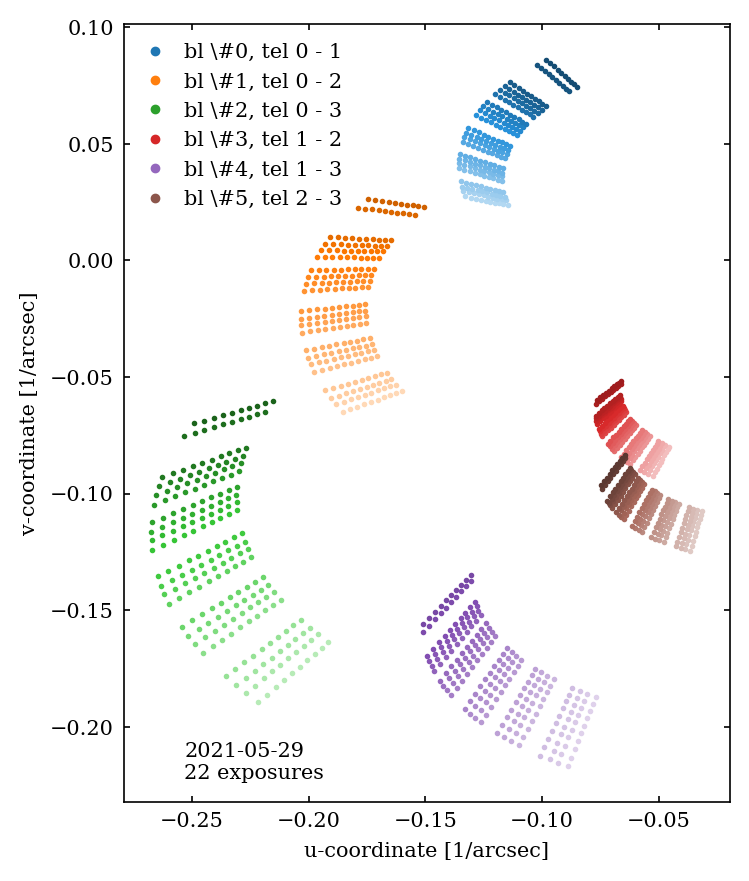

In [15]:
grav.plot_uv_coverage(data)

# Response, Sky, Likelihood

In [16]:
extra_ps_coord = np.array(extra_ps_coord)

In [17]:
# 2. RESPONSE
# -----------

# extra (= non-variable) point sources
# routines need to read/write to the phasemaps so execute on a single thread
extra_ps_n         = len(extra_ps_coord)
extra_ps_injection = [[],]*data['nbl']
extra_ps_flux_keys = []
extra_ps_pos_keys  = []
extra_ps_response  = []
if extra_ps_n > 0:
    # if present, the cental ps has index 1 so here we count from 2 upwards
    extra_ps_flux_keys = ['source{:d}_flux'.format(ips+2) for ips in range(extra_ps_n)]
    extra_ps_pos_keys  = [['source{:d}_ra'.format(ips+2), 'source{:d}_dec'.format(ips+2)] for ips in range(extra_ps_n)]
    extra_ps_injection = np.full( [data['nbl'], extra_ps_n, 2, data['nlam']], np.nan)
    cmap_param         = [image_domain, cmap_file, 1., phasemap_clip_low]
    for ips in range(extra_ps_n):
        rtmp, itmp = grav.point_source_visibility(data, extra_ps_coord[ips], bw_resolution, extra_ps_pos_keys[ips],\
                                                    *cmap_param, data_use_closure)
        extra_ps_response.append(rtmp)
        extra_ps_injection[:,ips,:,:] = itmp
extra_ps_response = np.array(extra_ps_response)
extra_ps_pos_keys = np.array(extra_ps_pos_keys)
extra_ps_coord    = np.array(extra_ps_coord)

# define domains
dom_rr     = ift.DomainTuple.make( [image_domain, ift.UnstructuredDomain(data['nlam'])])
dom_alpha  = ift.ContractionOperator(ift.UnstructuredDomain(data['nlam']), spaces=0).target
dom_lh     = ift.DomainTuple.make( [ift.UnstructuredDomain(1 + int(data_use_closure)*int(np.sum(data['closures']==0))),\
                                    ift.UnstructuredDomain(data['nframe']),\
                                    ift.UnstructuredDomain(data['npol']),\
                                    ift.UnstructuredDomain(data['nlam'])] )
dom_bw     = ift.DomainTuple.make( [ift.UnstructuredDomain(1 + int(data_use_closure)*int(np.sum(data['closures']==0))),\
                                    ift.UnstructuredDomain(data['nframe']),\
                                    ift.UnstructuredDomain(data['npol']),\
                                    ift.UnstructuredDomain(data['nlam']*bw_resolution)] )

    
# define the  multi-domain for the full model
dom_sky    = {'sky_alpha2' : image_domain, 'alpha1' : dom_alpha, 'alpha2' : dom_alpha, 'flux_bkg' : dom_alpha,\
              'alpha_bkg' : dom_alpha}
dom_sky['source1_ra']  = dom_alpha
dom_sky['source1_dec'] = dom_alpha
for ips in range(extra_ps_n):
    dom_sky[extra_ps_pos_keys[ips,0]] = dom_alpha
    dom_sky[extra_ps_pos_keys[ips,1]] = dom_alpha
    dom_sky[extra_ps_flux_keys[ips]]  = dom_alpha
            
if free_scale_bl == True:
    key_base = 'xi_scale_bl{:d}'
    for ibl in range(data['nbl']):
            dom_sky[key_base.format(ibl)] = ift.UnstructuredDomain(data['nframe'])
        
# specific to the first polarization
dom_sky_p1 = dom_sky.copy()
dom_sky_p1['variability_p1'] = ift.UnstructuredDomain(data['nframe'])
    
# specific to the second polarization
dom_sky_p2 = dom_sky.copy()
dom_sky_p2['variability_p2'] = ift.UnstructuredDomain(data['nframe'])
    
# create multi-domains
dom_sky    = ift.MultiDomain.make({**dom_sky_p1, **dom_sky_p2})
dom_sky_p1 = ift.MultiDomain.make(dom_sky_p1)
dom_sky_p2 = ift.MultiDomain.make(dom_sky_p2)
    
# operators which do not depend on baseline
explam = ift.ContractionOperator(dom_rr, spaces=1).adjoint

# central, variable point-source
ps_fiber_injection = [None]*data['nbl']
rr0 = None
cmap_param = [image_domain, cmap_file, 1., phasemap_clip_low]
rr0, ps_fiber_injection = grav.point_source_visibility(data, sgra_coord_mean, bw_resolution,\
                                                    ['source1_ra', 'source1_dec'], *cmap_param, data_use_closure)
ps_fiber_injection *= sgra_point_scale
    
# lists to hold baseline-dependent operators
rr_bl  = np.empty((2, data['nbl']), dtype=grav.PhasemapResponse)
sn_bl  = np.empty((data['npol'], data['nbl']), dtype=grav.NormOp_PmLSB)


# assign baseline dependent operators
for ibl in range(data['nbl']):

    # visibility normalization
    kwargs_norm = {'clip_low'  : phasemap_clip_low,\
                   'injection' : ps_fiber_injection[ibl],\
                   'extra_ps_flux_keys' : extra_ps_flux_keys,\
                   'extra_ps_injection' : extra_ps_injection[ibl],\
                   'phasemap_kernel'    : phasemap_kernel_stddev}
    sn_bl[:,ibl] = grav.get_NormOp_bl('deterministic', data, ibl, [dom_sky_p1, dom_sky_p2], cmap_file, kwargs_norm)

    # interferometric equation: rr implements the fourier transform
    rr = grav.PhasemapResponse(dom_rr, data, bw_resolution, 1e-4, cmap_file, ibl, 1., clip_low=phasemap_clip_low,\
                                use_closure=data_use_closure, phasemap_kernel=phasemap_kernel_stddev)

    # response w/ variable spectral index
    spec1 = grav.make_variable_spectrum_op(data, bw_resolution, ibl, dom_sky, 'alpha1', use_closure=data_use_closure)
    spec2 = grav.make_variable_spectrum_op(data, bw_resolution, ibl, dom_sky, 'alpha2', use_closure=data_use_closure)
    rr_bl[0,ibl] = spec1* sgra_point_scale *rr0[ibl]
    rr_bl[1, ibl] = rr @ explam @ ift.ducktape(image_domain, dom_sky, 'sky_alpha2')

    # add external point sources
    for ips in range(extra_ps_n):
        expvis  = ift.ContractionOperator(spec2.target, spaces=(0,1,2)).adjoint
        flux_op = expvis @ ift.FieldAdapter(dom_alpha, extra_ps_flux_keys[ips])
        rr_bl[1,ibl] = rr_bl[1,ibl] + (flux_op* extra_ps_response[ips,ibl])
    rr_bl[1,ibl] = spec2* rr_bl[1,ibl]
            
# assemble the full visibility    
exppol_1 = ift.ContractionOperator(dom_bw, spaces=(0,2,3)).adjoint
exppol_2 = ift.ContractionOperator(dom_bw, spaces=2).adjoint
exppol_3 = ift.ContractionOperator(dom_bw, spaces=(0,2)).adjoint

# operator to multiply each polarization state by its lightcurve
flux     = exppol_1 @ ift.FieldAdapter(dom_sky['variability_p1'], 'variability_p1')
if data['npol'] == 2:
    # make sure that each lightcurve is applied to the correct polarization state
    mask_p1 = np.zeros(dom_bw.shape)
    mask_p1[:, :, 0,:] = 1.
    mask_p1 = ift.makeOp(ift.makeField(dom_bw, mask_p1))
    mask_p2 = np.zeros(dom_bw.shape)
    mask_p2[:, :, 1,:] = 1
    mask_p2 = ift.makeOp(ift.makeField(dom_bw, mask_p2))
    flux    = (mask_p1 @ exppol_1 @ ift.FieldAdapter(dom_sky['variability_p1'], 'variability_p1')) +\
              (mask_p2 @ exppol_1 @ ift.FieldAdapter(dom_sky['variability_p2'], 'variability_p2'))

# put together the visibility
vis = [ exppol_2 @ rr_bl[1,ibl] + flux*(exppol_2 @ rr_bl[0,ibl]) for ibl in range(data['nbl'])]

# apply bandwidth smearing/average over sub-channel resolution
bws = grav.BWS_Average(dom_bw, bw_resolution)
vis = [ bws @ vv for vv in vis]
        
# combine the normalization operators for both polarizations
exppol = ift.ContractionOperator(dom_lh, spaces=(0,2)).adjoint
if data['npol'] == 2:
    # make sure that each lightcurve is applied to the correct polarization state
    mask_p1 = np.zeros(dom_lh.shape)
    mask_p1[:, :, 0,:] = 1.
    mask_p1 = ift.makeOp(ift.makeField(dom_lh, mask_p1))
    mask_p2 = np.zeros(dom_lh.shape)
    mask_p2[:, :, 1,:] = 1
    mask_p2 = ift.makeOp(ift.makeField(dom_lh, mask_p2))
    sn_bl = [(mask_p1 @ exppol @ sn_bl[0,ibl]) + (mask_p2 @ exppol @ sn_bl[1,ibl]) for ibl in range(data['nbl'])]
else:
    sn_bl = [ exppol @ sn_bl[0,ibl] for ibl in range(data['nbl'])]

# apply normalization to the visibilities
vis = [ sn_bl[ibl]*vis[ibl] for ibl in range(data['nbl']) ]

# apply amplitude calibration
if free_scale_bl == True:
    expop = ift.ContractionOperator(dom_lh, spaces=(0,2,3)).adjoint.real
    scale_bl = grav.amplitude_calibration(data, data_use_closure, sigma=free_scale_bl_sigma, key_base=key_base)
    vis = [(expop @ scale_bl[ibl])*vis[ibl] for ibl in range(data['nbl'])]

In [18]:
# 3. SKY MODEL
#-------------    
# 3.a) spatial distributions
# -> sky_alpha1 = variable
# -> sky_alpha2 = static 

invG_param['domain'] = image_domain
sky_alpha2 = ift.InverseGammaOperator(**invG_param) @ ift.FieldAdapter(image_domain, 'xi_sky_alpha2')
sky = ift.ducktape(dom_sky, image_domain, 'sky_alpha2') @ sky_alpha2
sky_lam0  = sky_alpha2
ps_ops = []

    
# sky model for the inference
pos_scale = ift.ScalingOperator(dom_alpha, spix)
ra_op     = pos_scale @ ift.FieldAdapter(dom_alpha, 'xi_source1_ra').real
dec_op    = pos_scale @ ift.FieldAdapter(dom_alpha, 'xi_source1_dec').real
sky = sky + ift.ducktape(dom_sky, dom_alpha, 'source1_ra')  @ ra_op
sky = sky + ift.ducktape(dom_sky, dom_alpha, 'source1_dec') @ dec_op
flux_op   = ift.ScalingOperator(dom_alpha, sgra_point_scale) @ ift.ScalingOperator(dom_alpha, 0.).exp() @ \
            ift.FieldAdapter(dom_alpha, 'xi_source1_dec').real # hack to get a constant operator
ps_ops.append([ra_op, dec_op, flux_op])

# extra point sources
for ips in range(extra_ps_n):
    pos_scale = ift.ScalingOperator(dom_alpha, extra_ps_sigma[ips])
    ra_op     = ift.Adder(ift.full(dom_alpha, extra_ps_coord[ips,0])) @ pos_scale @\
                ift.FieldAdapter(dom_alpha, 'xi_'+extra_ps_pos_keys[ips,0]).real
    dec_op    = ift.Adder(ift.full(dom_alpha, extra_ps_coord[ips,1])) @ pos_scale @\
                ift.FieldAdapter(dom_alpha, 'xi_'+extra_ps_pos_keys[ips,1]).real
    flux_op   = ift.FieldAdapter(dom_alpha, 'xi_'+extra_ps_flux_keys[ips]).real.exp()
        
    sky = sky + ift.ducktape(dom_sky, dom_alpha,  extra_ps_pos_keys[ips,0]) @ ra_op
    sky = sky + ift.ducktape(dom_sky, dom_alpha,  extra_ps_pos_keys[ips,1]) @ dec_op
    sky = sky + ift.ducktape(dom_sky, dom_alpha,  extra_ps_flux_keys[ips] ) @ flux_op

    ps_ops.append( [ra_op, dec_op, flux_op])
ps_ops = np.array(ps_ops)
        
# 3.b) lightcurve

# uncorrelated frames
frames = ift.ScalingOperator(ift.UnstructuredDomain(data['nframe']), 1.)
time_corr_p1 = ift.FieldAdapter(dom_sky['variability_p1'], 'xi_variability_p1').exp()
time_corr_p2 = ift.FieldAdapter(dom_sky['variability_p2'], 'xi_variability_p2').exp()
 
variability = ift.ducktape(dom_sky, dom_sky['variability_p1'], 'variability_p1') @ frames @ time_corr_p1.real
brightness  = [time_corr_p1]
if data['npol']==2:
    variability = variability + ift.ducktape(dom_sky, dom_sky['variability_p2'], 'variability_p2') @\
    frames @ time_corr_p2.real
    brightness.append(time_corr_p2)
        
# 3.c) full sky
sky    = sky + variability

# 3.d) spectral indices
alpha1_op = ift.FieldAdapter(dom_alpha, 'xi_alpha1').real
alpha1_op = ift.ScalingOperator(dom_alpha, alpha1_var) @ alpha1_op
alpha1_op = ift.Adder(ift.makeField(dom_alpha, alpha1)) @ alpha1_op
        
alpha2_op = ift.FieldAdapter(dom_alpha, 'xi_alpha2').real
alpha2_op = ift.ScalingOperator(dom_alpha, alpha2_var) @ alpha2_op
alpha2_op = ift.Adder(ift.makeField(dom_alpha, alpha2)) @ alpha2_op
        
sky = sky + ift.ducktape(dom_sky, dom_alpha, 'alpha1') @ alpha1_op
sky = sky + ift.ducktape(dom_sky, dom_alpha, 'alpha2') @ alpha2_op

# 3.e) background flux
alpha_bg_op = ift.FieldAdapter(dom_alpha, 'xi_alpha_bkg').real
alpha_bg_op = ift.ScalingOperator(dom_alpha, alpha_bg_var)  @ alpha_bg_op
alpha_bg_op = ift.Adder(ift.makeField(dom_alpha, alpha_bg)) @ alpha_bg_op

flux_bg_op = ift.FieldAdapter(dom_alpha, 'xi_flux_bkg').real
flux_bg_op = ift.ScalingOperator(dom_alpha, bkg_var) @ flux_bg_op
flux_bg_op = ift.Adder(ift.makeField(dom_alpha, bkg_level)) @ flux_bg_op
flux_bg_op = flux_bg_op.clip(a_min=0., a_max=None)

sky = sky + ift.ducktape(dom_sky, dom_alpha, 'alpha_bkg') @ alpha_bg_op
sky = sky + ift.ducktape(dom_sky, dom_alpha, 'flux_bkg') @ flux_bg_op


# 3.f) free amplitude scaling per baseline
if free_scale_bl:
    for sb in scale_bl:
        name = sb.domain.keys()[0]
        sky = sky + ift.ducktape(dom_sky, dom_sky[name], name) @ ift.FieldAdapter(dom_sky[name], name)

In [19]:
# 4. LIKELIHOOD
# -------------
# organize the visibilities in a Multi-Field
# naming convention = bl-{idx_tel1}-{idx_tel2} w/ telescope indices staring at 0 as in data['baselines']
# this convention is also assumed by the likelihood
bl_names = ['bl-{:d}-{:d}'.format(tel[0], tel[1]) for tel in data['baselines']]
mdom_lh  = {nn : dom_lh for nn in bl_names}
  
vis_lh_bare = [ift.ducktape(mdom_lh, dom_lh, bl_names[ii]) @ vis[ii] for ii in range(data['nbl'])]
vis_lh_bare = reduce(add, vis_lh_bare)
vis = [vv @ sky for vv in vis]

# get the likelihood
lhs = grav.get_likelihood(data, lh_type, data_selection)    
vis_lh = [ift.ducktape(mdom_lh, dom_lh, bl_names[ii]) @ vis[ii] for ii in range(data['nbl'])]
vis_lh = reduce(add, vis_lh)
lh     = reduce(add, lhs)
lh     = lh @ vis_lh

In [20]:
pos_final = ift.MultiField.from_dict(pos_final, domain=lh.domain)

# Imaging Solution

## Images and Source Detection

In [21]:
sc_ps    = [ift.StatCalculator() for ips in range(3*len(ps_ops))]
for ss in samples:
    for ips in range(ps_ops.shape[0]):
        for pp in range(ps_ops.shape[1]):
            if pp==2:
                sc_ps[3*ips+pp].add(ps_ops[ips,pp].force(pos_final+ss)/ps_ops[1,pp].force(pos_final+ss))
            else:
                sc_ps[3*ips+pp].add(ps_ops[ips,pp].force(pos_final+ss))
                    
ps_pos_flux = np.full(ps_ops.shape + (2,), np.nan)
for ips in range(ps_ops.shape[0]):
    for pp in range(ps_ops.shape[1]):
        ps_pos_flux[ips,pp,0] = sc_ps[3*ips+pp].mean.val
        ps_pos_flux[ips,pp,1] = sc_ps[3*ips+pp].var.sqrt().val

In [22]:
if sgra_coord_std==0:
    ps_pos_flux[0,:2,1] = 0.

In [23]:
for ips in range(ps_ops.shape[0]):
    print('source {:d}: RA={:.4f}+-{:.4f} mas, Dec={:.4f}+-{:.4f}mas, flux={:.4f}+-{:.4f}'.\
          format(ips+1, *ps_pos_flux[ips,0,:], *ps_pos_flux[ips,1,:], *ps_pos_flux[ips,2,:]))

source 1: RA=0.0000+-0.0000 mas, Dec=0.0000+-0.0000mas, flux=0.0562+-0.0092
source 2: RA=2.8096+-0.0073 mas, Dec=-11.5841+-0.0105mas, flux=1.0000+-0.0000
source 3: RA=29.2064+-0.0181 mas, Dec=19.1153+-0.0144mas, flux=0.7008+-0.0036
source 4: RA=-13.0802+-0.0165 mas, Dec=13.0962+-0.0182mas, flux=0.1961+-0.0023


In [24]:
print('S29 prior offset RA = {:.2f}, Dec = {:.2f}'.format( *(ps_pos_flux[1,:2,0]-extra_ps_coord[0])))

S29 prior offset RA = 0.01, Dec = 0.02


In [25]:
print('S55 prior offset RA = {:.2f}, Dec = {:.2f}'.format( *(ps_pos_flux[2,:2,0]-extra_ps_coord[1])))

S55 prior offset RA = 0.01, Dec = 0.02


In [26]:
print('S62 prior offset RA = {:.2f}, Dec = {:.2f}'.format( *(ps_pos_flux[3,:2,0]-extra_ps_coord[2])))

S62 prior offset RA = 0.02, Dec = -0.00


In [27]:
norm_op = ift.ContractionOperator(image_domain, spaces=0).adjoint @ ps_ops[1,2]
sc_image = ift.StatCalculator()
for ss in samples:
    sc_image.add(sky_lam0.force(pos_final+ss)/norm_op.force(pos_final+ss))

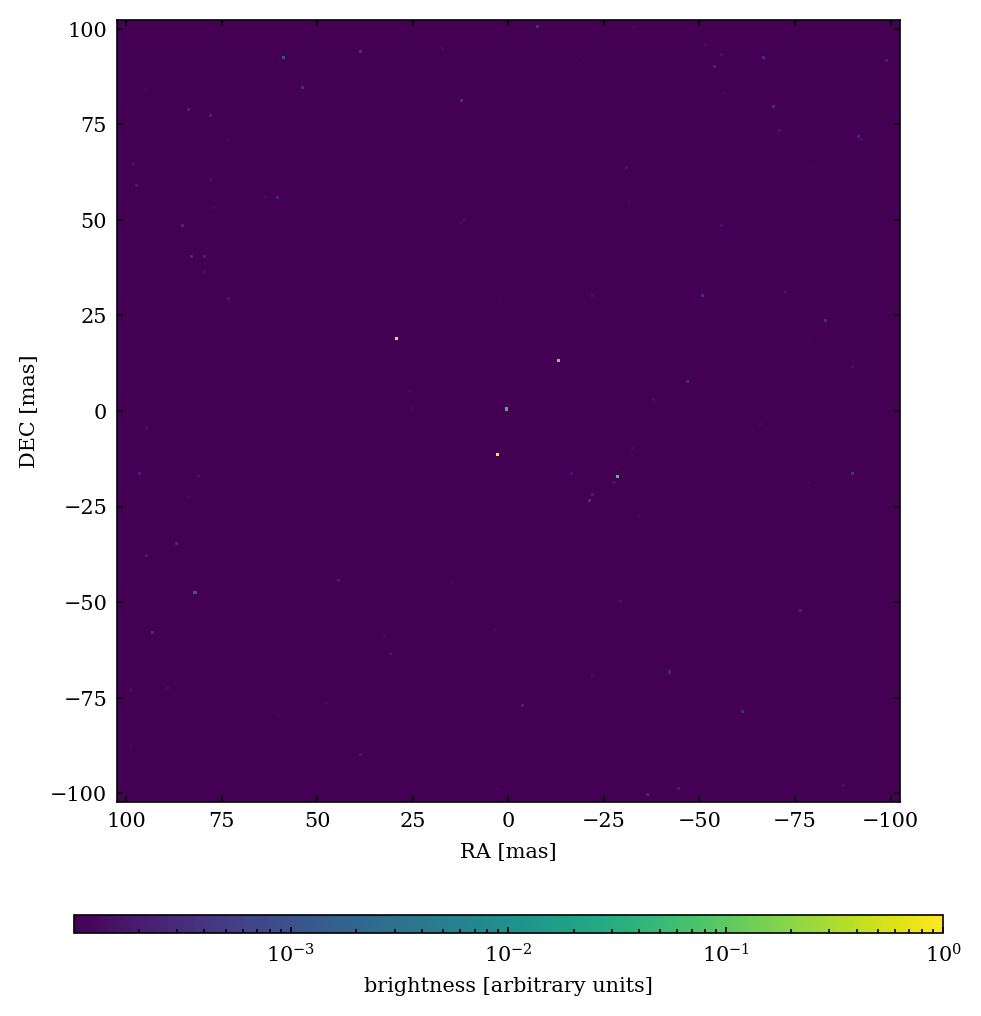

In [28]:
fig = grav.plot_image(sc_image.mean, None, fov=fov, logscale=True, extra_ps=ps_pos_flux[:,:,0])
fig

In [29]:
sourcelist = [[2.8, -11.6],[29.2, 19.1],[-13.1, 13.1], [-28.4,-18.8]]

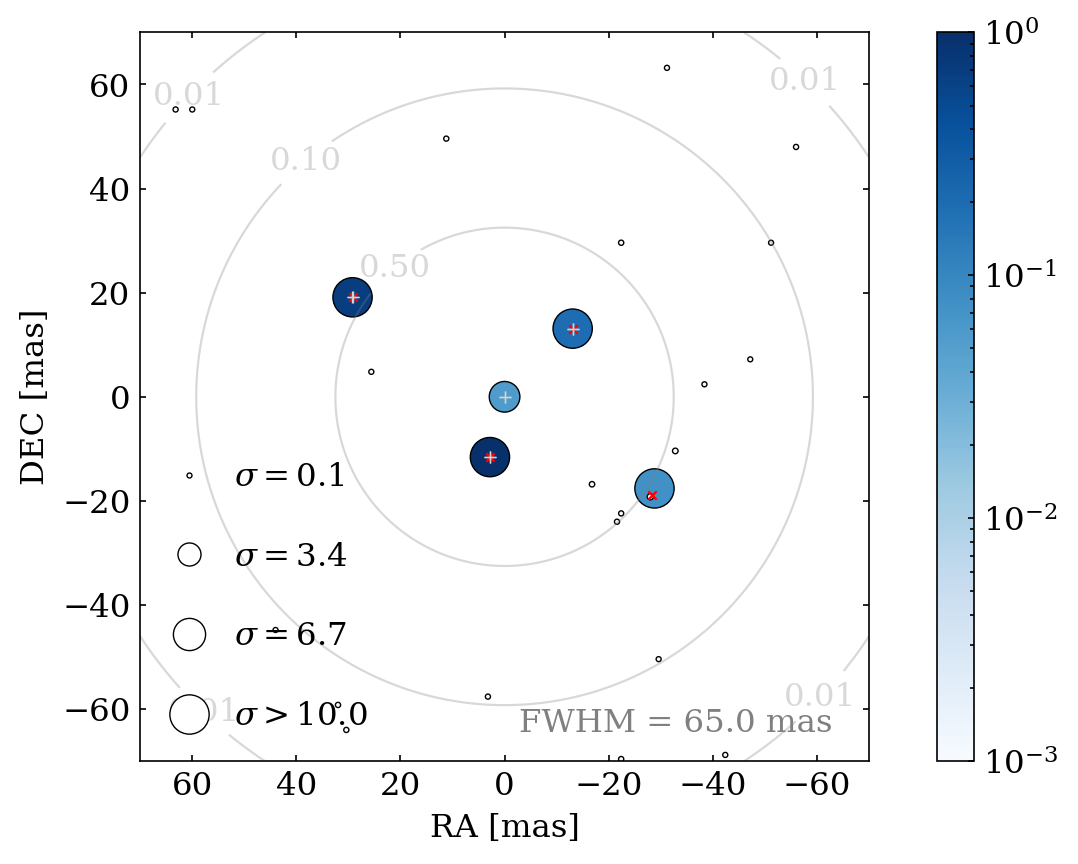

In [30]:
fig = grav.plot_image_samples(sc_image, 140, sourcelist=sourcelist, fiber_fwhm=65, extra_ps=ps_pos_flux,\
                              vmin=1e-3, vmax=1., fontsize=14)
fig

In [31]:
mean_image = sc_image.mean.val.copy()
std_image  = sc_image.var.sqrt().val.copy()
for ii in range(10):
    idx = np.unravel_index(np.argmax(mean_image, axis=None), mean_image.shape)
    print(idx, '\t', np.array(idx)*spix-fov/2, '\t\t',\
          'flux/S29 = {:.3f} +- {:.3f}'.format(mean_image[idx], std_image[idx]))
    mean_image[idx] = 0.

(92, 106) 	 [-28.8 -17.6] 		 flux/S29 = 0.075 +- 0.003
(230, 68) 	 [ 81.6 -48. ] 		 flux/S29 = 0.001 +- 0.008
(201, 243) 	 [58.4 92. ] 		 flux/S29 = 0.001 +- 0.007
(15, 107) 	 [-90.4 -16.8] 		 flux/S29 = 0.000 +- 0.003
(101, 98) 	 [-21.6 -24. ] 		 flux/S29 = 0.000 +- 0.002
(176, 245) 	 [38.4 93.6] 		 flux/S29 = 0.000 +- 0.002
(41, 227) 	 [-69.6  79.2] 		 flux/S29 = 0.000 +- 0.002
(118, 253) 	 [ -8. 100.] 		 flux/S29 = 0.000 +- 0.002
(24, 157) 	 [-83.2  23.2] 		 flux/S29 = 0.000 +- 0.002
(244, 55) 	 [ 92.8 -58.4] 		 flux/S29 = 0.000 +- 0.002


## Lightcurves

In [32]:
cop     = ift.ContractionOperator(brightness[0].target, spaces=0).adjoint
bb_norm = [bb*(cop @ ps_ops[1,2]**(-1.0)) for bb in brightness]

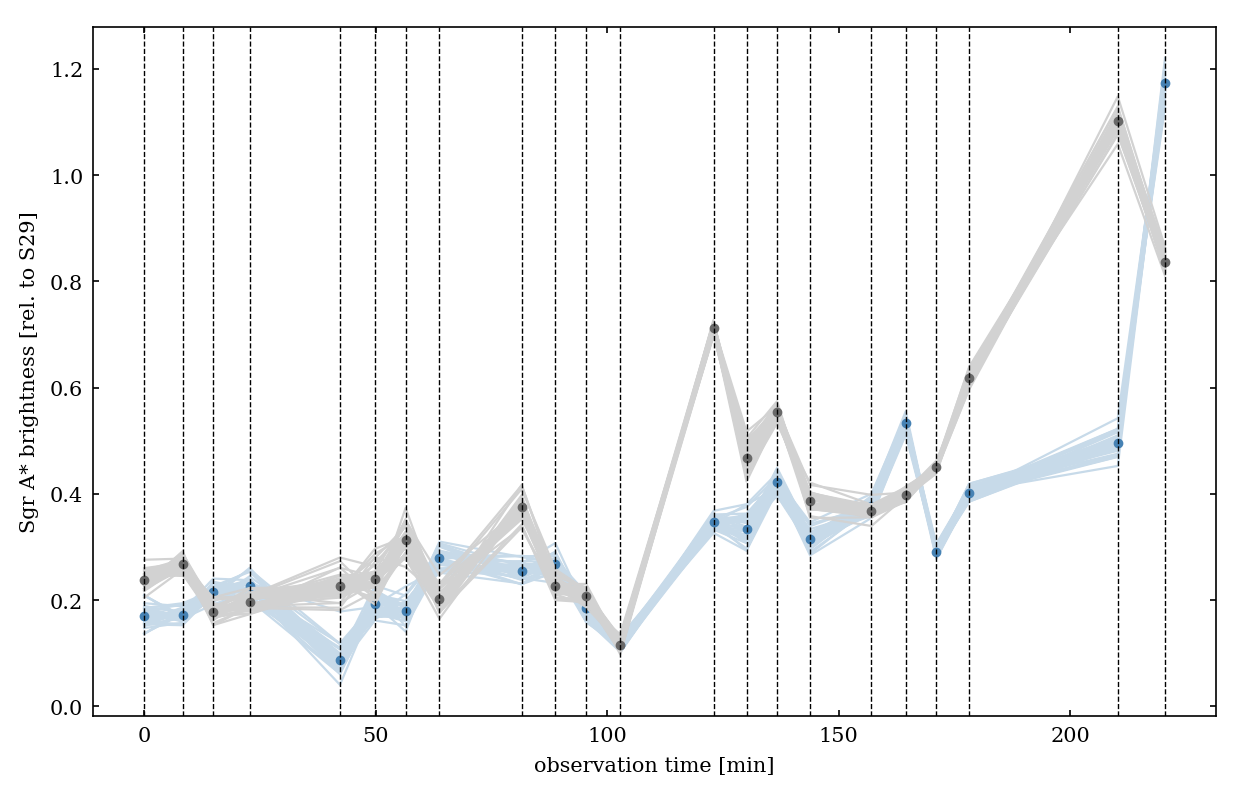

In [33]:
grav.plot_brightness_evolution_samples(bb_norm, pos_final, samples, tmax, times=data['tim'],\
                                       ylabel='Sgr A* brightness [rel. to S29]')

## Spectral indices

In [34]:
sc1 = ift.StatCalculator()
sc2 = ift.StatCalculator()
sc3 = ift.StatCalculator()
    
for ss in samples:
        sc1.add(alpha1_op.force(pos_final+ss))
        sc2.add(alpha2_op.force(pos_final+ss))
        sc3.add((alpha1_op-alpha2_op).force(pos_final+ss))
print('alpha1 = {:.3f} +- {:.3f}'.format(sc1.mean.val, sc1.var.sqrt().val))
print('alpha2 = {:.3f} +- {:.3f}'.format(sc2.mean.val, sc2.var.sqrt().val))
print('Dalpha = {:.3f} +- {:.3f}'.format(sc3.mean.val, sc3.var.sqrt().val))

alpha1 = -0.541 +- 1.639
alpha2 = 2.625 +- 1.644
Dalpha = -3.166 +- 0.095


## Amplitude calibration

In [35]:
sc_scale = [ift.StatCalculator() for ibl in range(data['nbl'])]
for ss in samples:
    for ibl, sbl in enumerate(scale_bl):
        sc_scale[ibl].add(sbl.force(pos_final+ss))
scale_mean = np.array([sbl.mean for sbl in sc_scale])
scale_std  = np.array([sbl.var.sqrt() for sbl in sc_scale])

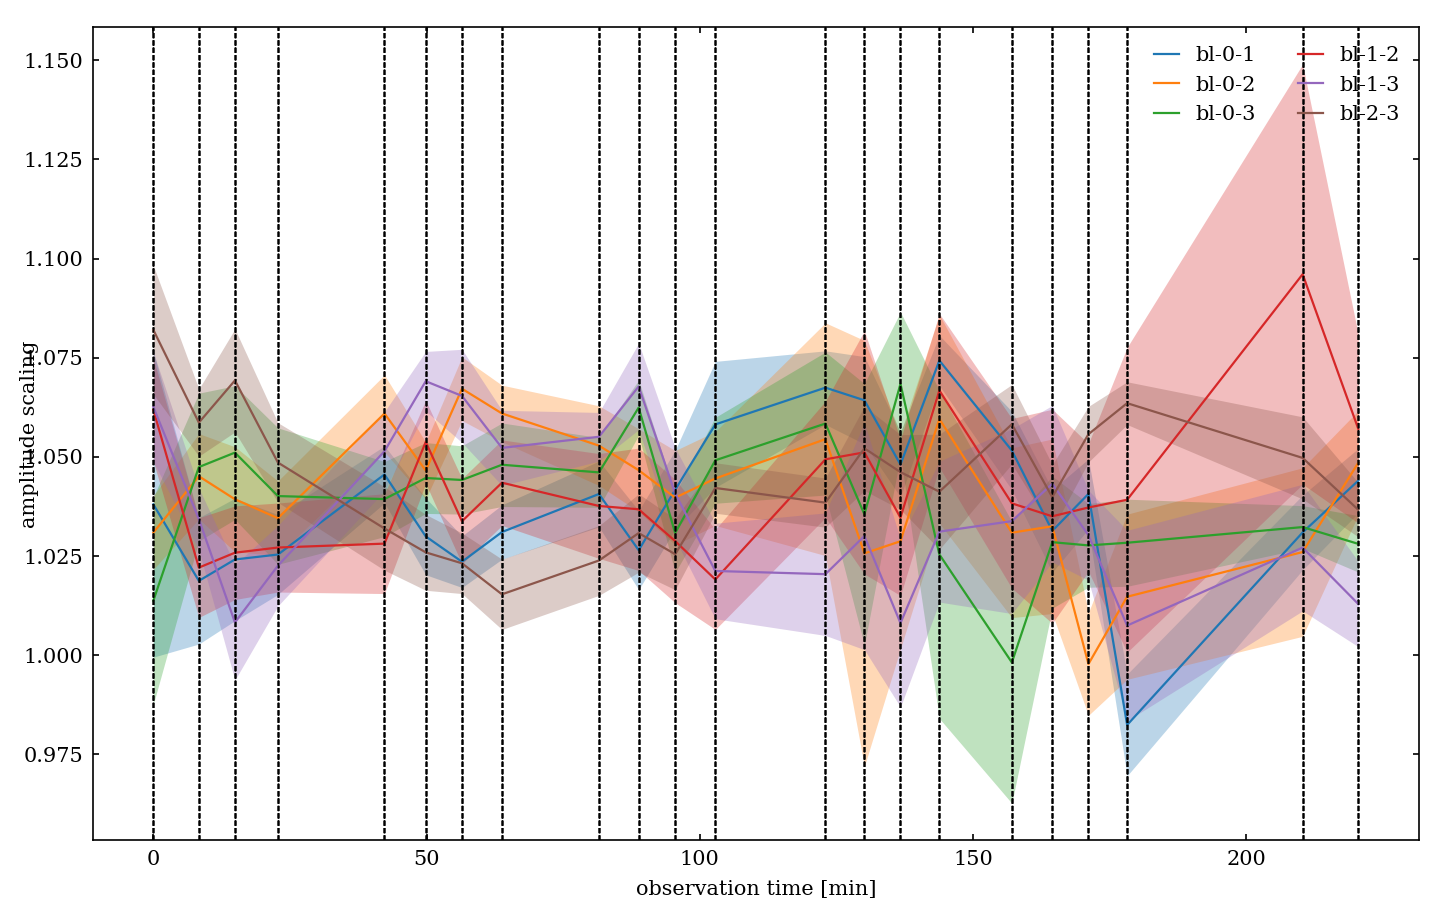

In [36]:
fig = grav.plot_scale_bl(scale_mean, None, data, var=scale_std)
fig

# Model vs. Data comparison

In [37]:
sc_sky = ift.StatCalculator()
for ss in samples:
    sc_sky.add(sky(pos_final+ss))
vis_mean_sky = vis_lh_bare(sc_sky.mean)

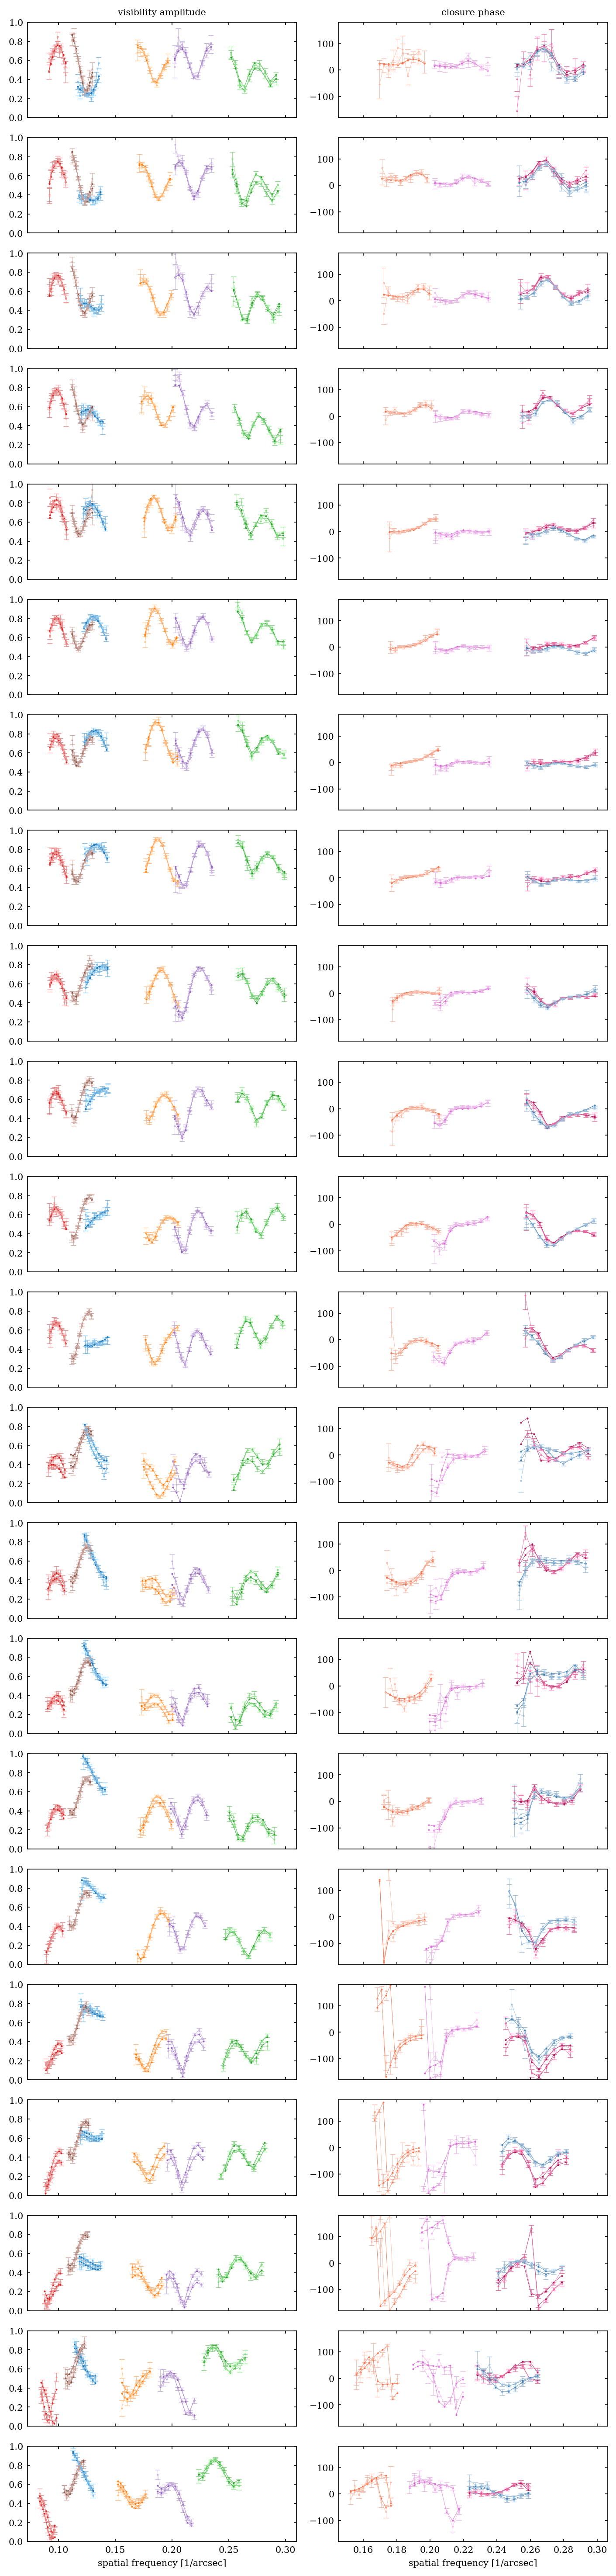

In [38]:
grav.plot_data_comparison(vis_mean_sky, data, data_selection)

## Residuals

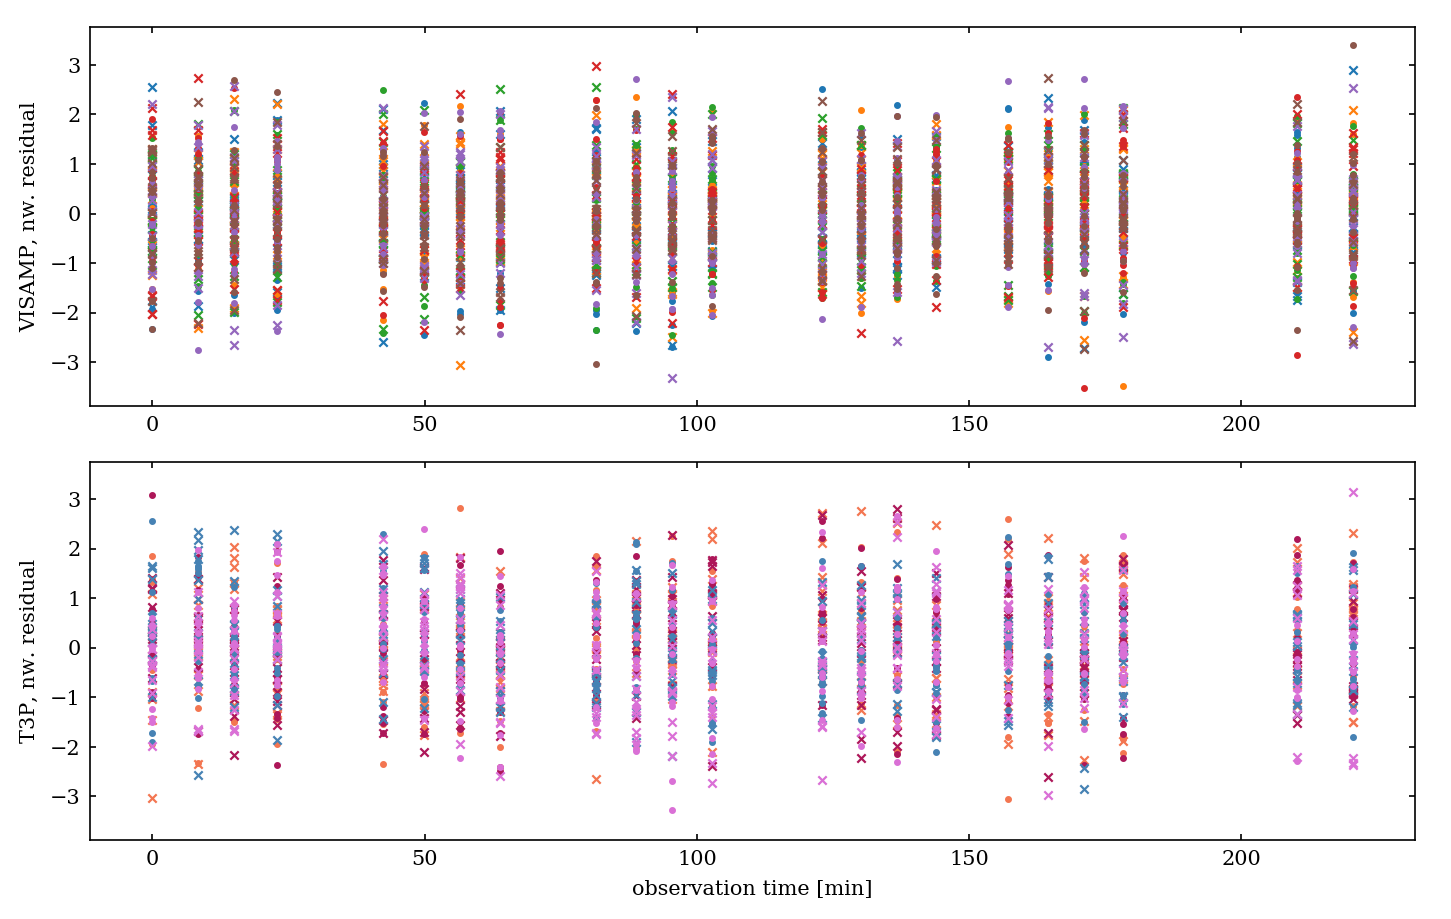

In [39]:
grav.plot_residuals_time(vis_mean_sky, data, data_selection, lh_type)

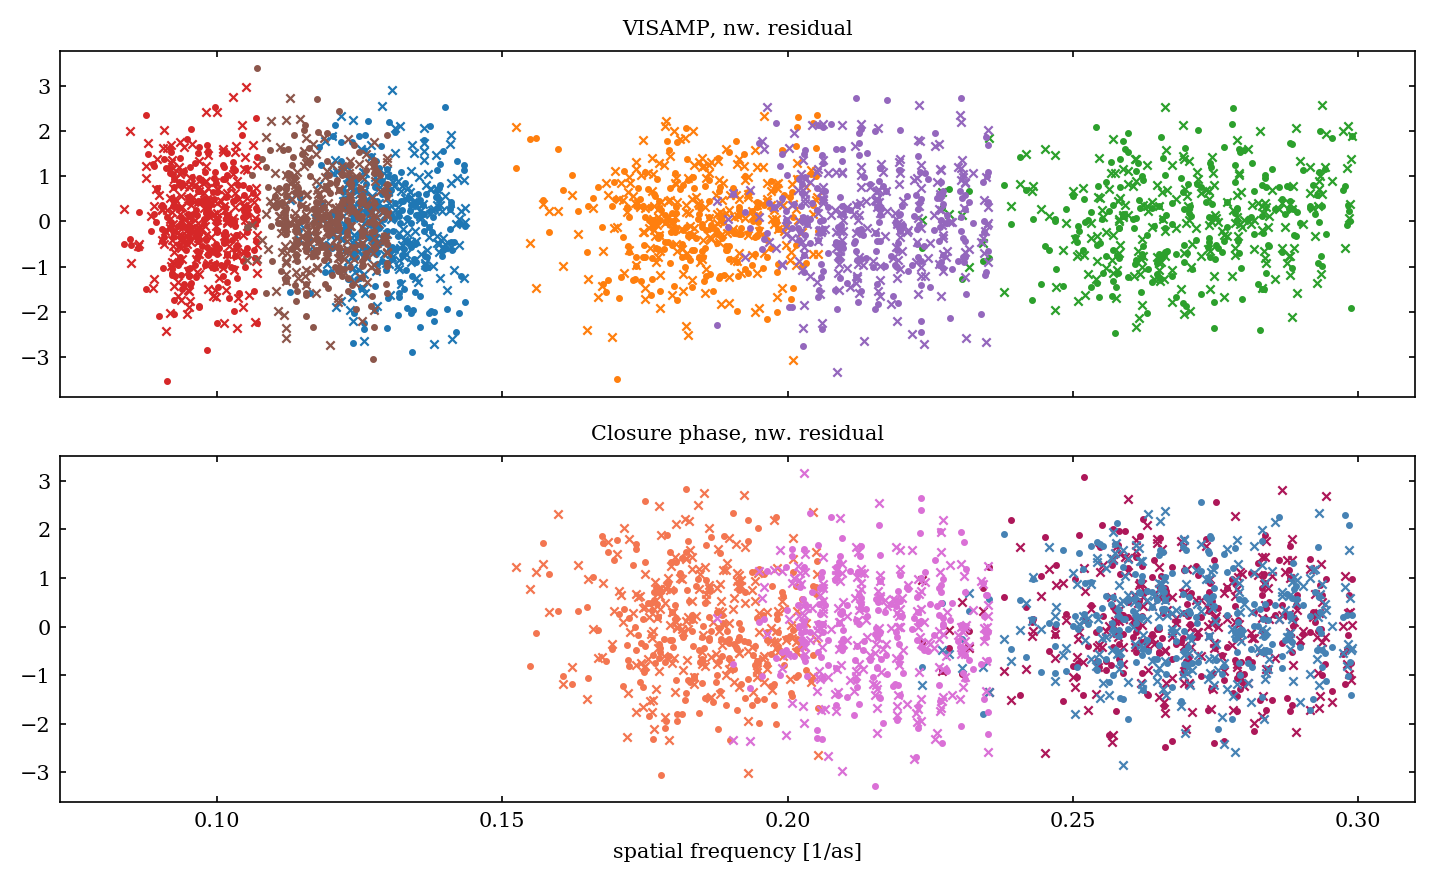

In [40]:
grav.plot_residuals_uv(vis_mean_sky, data, data_selection, lh_type)

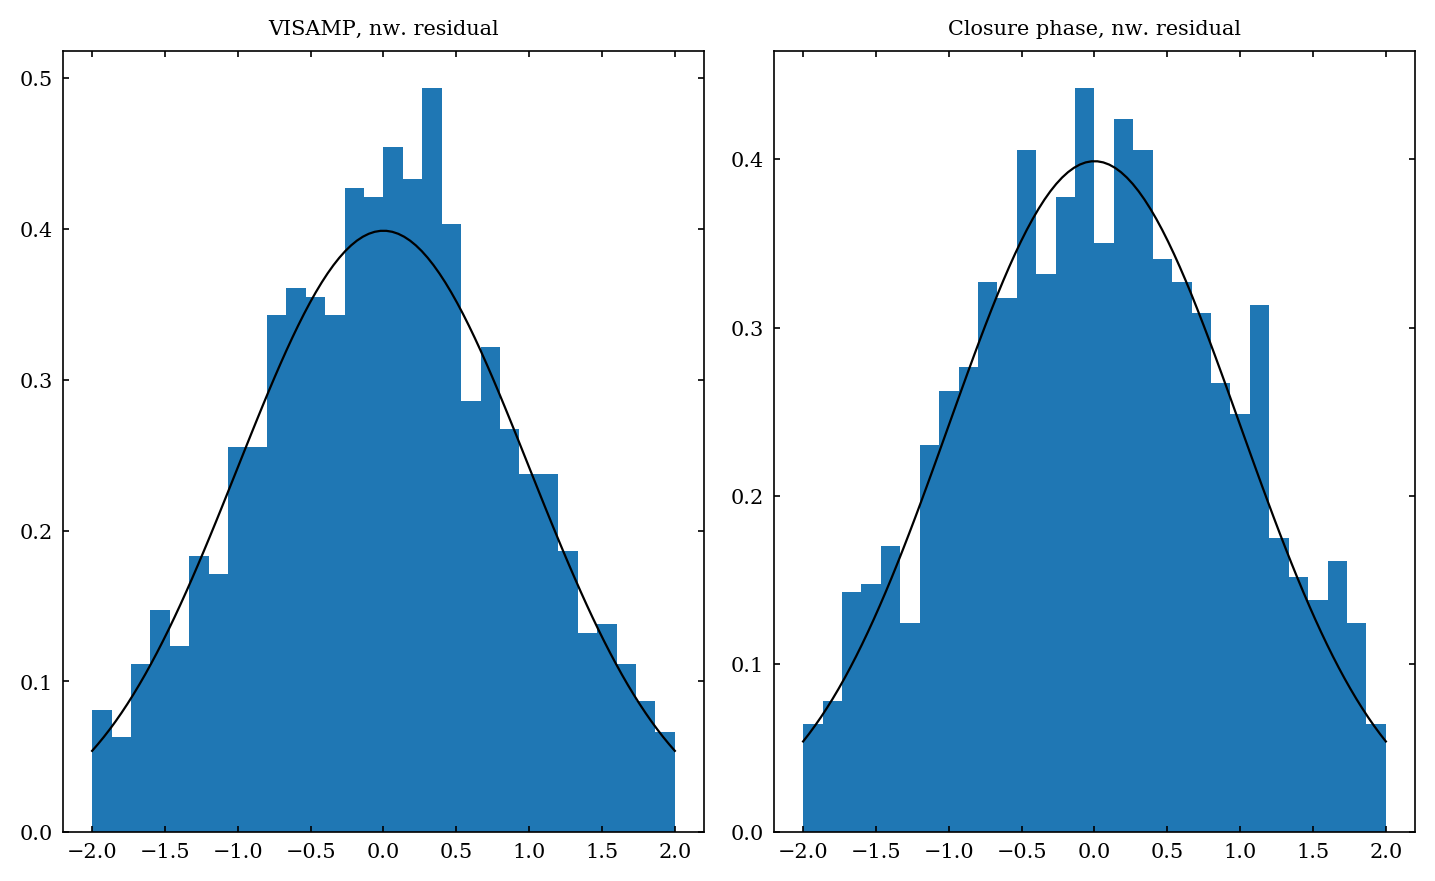

In [41]:
grav.plot_residuals_hist(vis_mean_sky, data, data_selection, lh_type)

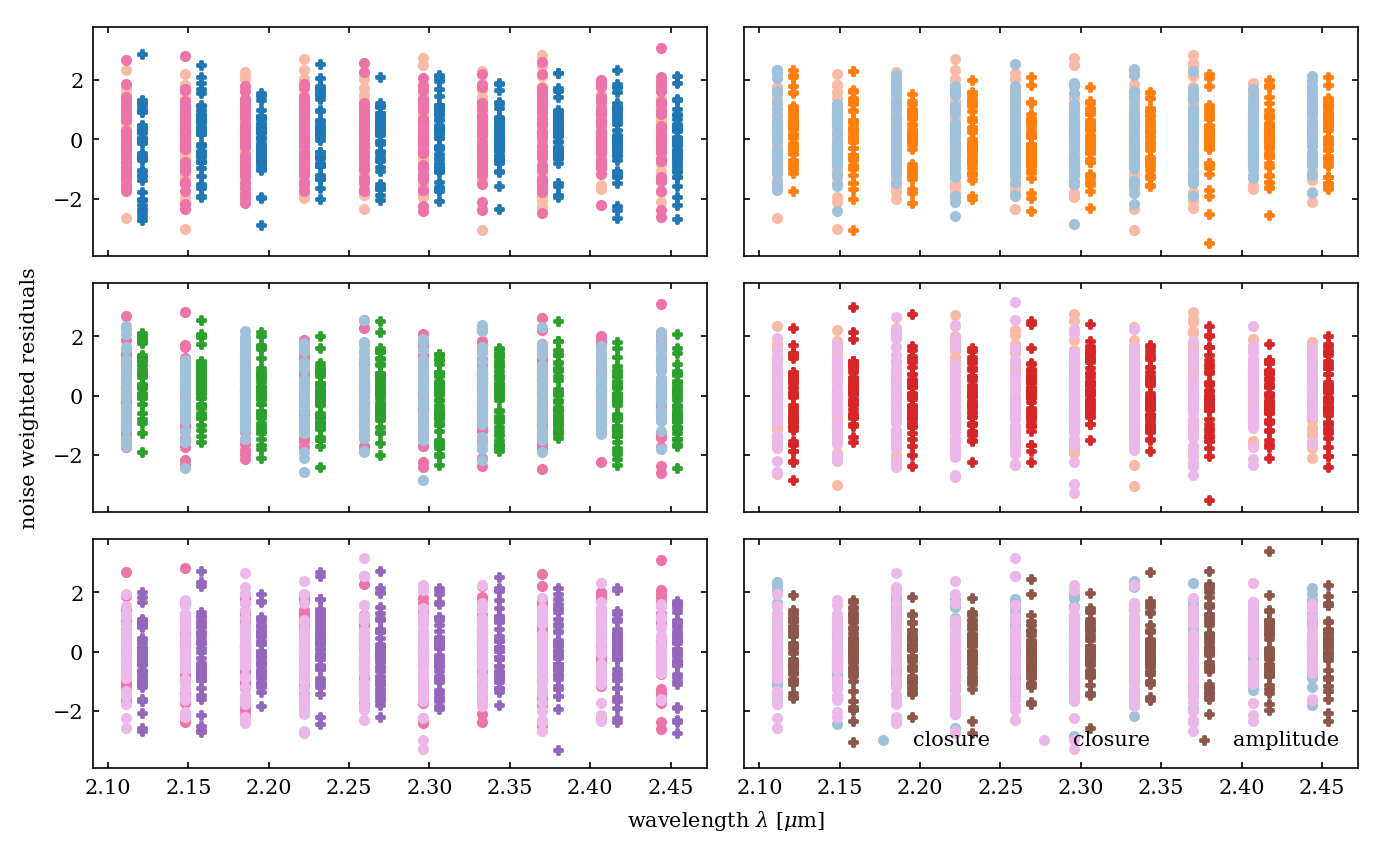

In [42]:
grav.plot_residuals_channel(vis_mean_sky, data, data_selection)